# Continuous Ranked Probability Score (CRPS) in probabilistic forecasting

## CRPS

The Continuous Ranked Probability Score (CRPS) is a commonly used metric for evaluating the predictions of probabilistic forecasting models.

In point estimate forecasting, the model outputs a single value that ideally represents the most likely value of the time series at future steps. In this scenario, the quality of the predictions can be assessed by comparing the predicted value with the true value of the series. Examples of metrics used for this purpose are the Mean Absolute Error (MAE) and the Root Mean Squared Error (RMSE).

In probabilistic forecasting, however, the model does not produce a single value, but rather a representation of the entire distribution of possible predicted values. In practice, this is often represented by a sample of the underlying distribution (e.g. 50 possible predicted values) or by specific quantiles that capture most of the information in the distribution.

One of the main applications of probabilistic forecasting is the estimation of prediction intervals - ranges within which the actual value is expected to fall with a certain probability. In this case, the model should aim to achieve the desired coverage (e.g. 80%) while minimising the width of the prediction interval.

The Continuous Ranked Probability Score (CRPS) is a generalization of the Mean Absolute Error (MAE) tailored for probabilistic forecasting. Unlike MAE, which compares point predictions to observed values, CRPS evaluates the accuracy of an entire forecasted probability distribution against the observed value. It achieves this by comparing the empirical cumulative distribution function (CDF) of the predicted values with the step-function CDF of the true value. 

Two key components of the CRPS are the empirical CDF of the forecast, 𝐹(𝑦), and the CDF of the observed value, 𝐻(𝑦). The CRPS is then calculated as the integral of the squared difference between these two functions over the entire real line. Two 

Two key components of the CRPS are:

+ Empirical CDF of the Forecast, $F(y)$: This is constructed from the ensemble of predicted values. Each predicted value contributes a "step" in the cumulative distribution, effectively treating the ensemble as a sample of the underlying probability distribution.

+ CDF of the Observed Value, $H(y)$: This is a step function that transitions from 0 to 1 at the true observed value. It represents the probability that the observed value falls below a given threshold.

The CRPS measures the area between the two CDFs, $F(y)$ and $H(y)$, across all possible values of $y$. Mathematically, it is expressed as:


$$\text{CRPS}(F, H) = \int_{-\infty}^{\infty} \big(F(y) - H(y)\big)^2 \, dy$$


This integral quantifies the squared difference between the forecasted and observed distributions. Smaller values of CRPS indicate a better match between the forecast and the observed outcome.

CRPS is widely used in probabilistic forecasting because it provides a unified framework for evaluating both the sharpness (narrowness) and calibration (accuracy) of predictive distributions. By doing so, it ensures that models are not only accurate in their point predictions but also appropriately represent uncertainty.

**Intuition behind CRPS**

CRPS can be thought of as a continuous counterpart to MAE, but instead of comparing single values, it evaluates how well a forecasted distribution aligns with the observed outcome. Imagine overlaying the two CDFs (forecast and truth): the CRPS quantifies how "far apart" these curves are, with smaller areas indicating better alignment.

Lets consider the true value is 5 and the probabilistic forecasting model has predicted the following values: [3, 1, 4, 1, 5, 9, 2, 6, 5, 3]. The CRPS can be calculated as follows:

1. Sort the predicted values: [1, 1, 2, 3, 3, 4, 5, 5, 6, 9]
2. Calculate the empirical CDF of the forecast: [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
3. Calculate the CDF of the observed value: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
4. Calculate the squared difference between the two CDFs: [0.01, 0.04, 0.09, 0.16, 0.25, 0.36, 0.09, 0.04, 0.01, 0]
5. Multiply the squared difference by the step size (1): [0, 0, 1, 1, 0, 1, 1, 0, 1, 3]
6. Sum the values to get the CRPS

Note: This is a simplified example for illustrative purposes. In practice, the CRPS is calculated using an integral of the squared difference between the two CDFs over the entire real line.

<p style="text-align: center">
<img src="crps.gif" style="width: 600px;">
<br>
<font size="2.5"> <i>Example of CRPS calculation</i> </font>
</p>

**CRPS and Skforecast**

Skforecast provides different output options for probabilistic forecasting, two of which are:

- **`predict_bootstrapping`**: Returns multiple predicted values for each forecasted step. Each value is a variation of the forecast generated through bootstrapping. For a given step \(i\), \(n\) predictions are estimated.

- **`predict_quantile`**: Returns the estimated values for multiple quantiles. Internally, the forecaster uses `predict_bootstrapping` and then calculates the desired quantiles.

For both outputs, the CRPS (Continuous Ranked Probability Score) can be calculated to evaluate the forecasting performance of the model.


## CRPS from an sample of predictions

The Continuous Ranked Probability Score (CRPS) is calculated by comparing the empirical cumulative distribution function (ECDF) of the forecasted values to the step function CDF of the true value. When the available information consists of the true value (`y_true`) and a sample of predictions, the CRPS can be calculated by following these steps:

1. Generate the Empirical Cumulative Distribution Function (ECDF) of the predictions:
   - Sort the predictions.
   - Use each sorted prediction as a step in the ECDF.

2. Generate the Cumulative Distribution Function (CDF) of the true value:
   - Since there is only a single true value, this is represented as a step function that jumps from 0 to 1 at the observed value (`y_true`).

3. Calculate the CRPS by integrating the area between both curves:
   - This involves computing the squared differences between the forecasted ECDF and the true CDF, and then summing the areas between the two curves.


The follwing are multiple candidate functions to calculate the CRPS from a sample of predictions. Their results are compared with already implemented functions in the `properscoring`, `CRPS` and `pymc_marketing` libraries. `crps_from_predictions_4` seems to be the one that best approximates the reference implementations.

In [163]:
import numpy as np

def crps_from_predictions(
    y_truth: float,
    y_pred: np.ndarray,
    sample_weight = None,
) -> float:
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a set of
    explicit forecast realizations. The CRPS compares the empirical distribution
    of set of forecasted values to a scalar observation. The smaller the CRPS, the
    better.

    Source: addapted from https://juanitorduz.github.io/electricity_forecast/

    Parameters
    ----------
    y_truth : float
        The true value of the random variable.
    y_pred : np.ndarray
        The predicted values of the random variable. These are the multiple
        forecasted values for a single observation.
    sample_weight : np.ndarray, optional
        If provided, the CRPS is calculated exactly with the assigned probability weights
        to each forecasted sample. By default, each forecast is weighted equally.

    Returns
    -------
    float
        The CRPS score.
    """
    absolute_error = np.mean(np.abs(y_pred - y_truth), axis=0)
    num_samples = len(y_pred)
    if num_samples == 1:
        return np.average(absolute_error, weights=sample_weight)

    y_pred = np.sort(y_pred, axis=0)
    diff = y_pred[1:] - y_pred[:-1]
    weight = np.arange(1, num_samples) * np.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))
    per_obs_crps = absolute_error - np.sum(diff * weight, axis=0) / num_samples**2

    return np.average(per_obs_crps, weights=sample_weight)


# Custom implementation follwoing the cannonical implementation
def crps_from_predictions_2(y_truth: float, y_pred: np.ndarray) -> float:
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a set of
    explicit forecast realizations. The CRPS compares the empirical distribution
    of set of forecasted values to a scalar observation. The smaller the CRPS, the
    better.

    Parameters
    ----------
    y_truth : float
        The true value of the random variable.
    y_pred : np.ndarray
        The predicted values of the random variable. These are the multiple
        forecasted values for a single observation.

    Returns
    -------
    float
        The CRPS score.
    """
    # Sort predictions to construct the empirical CDF
    y_pred_sorted = np.sort(y_pred)
    n_pred = len(y_pred_sorted)

    # Initialize CRPS score
    crps = 0.0

    # For integration, calculate step size between consecutive predicted values
    for i in range(len(y_pred_sorted)):
        # Empirical CDF at current step
        F_yi = np.sum(y_pred_sorted <= y_pred_sorted[i]) / n_pred

        # Widht of the step (difference between current prediction and previous one)
        if i == 0:
            delta = y_pred_sorted[i]  # First step starts from 0
        else:
            delta = y_pred_sorted[i] - y_pred_sorted[i - 1]

        # Heigh of the step:Difference between empirical CDF and the true CDF (step function)
        H_diff = F_yi - (
            y_truth <= y_pred_sorted[i]
        )  # The second term is 0 for the range lower than y_true and 1 otherwhise

        # Increment CRPS (area of each rectangle)
        crps += H_diff**2 * delta

    return crps

# Same as crps_from_predictions_2 but vectorized
def crps_from_predictions_3(y_truth: float, y_pred: np.ndarray) -> float:
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a set of
    explicit forecast realizations. The CRPS compares the empirical distribution
    of a set of forecasted values to a scalar observation. The smaller the CRPS, the better.

    Parameters
    ----------
    y_truth : float
        The true value of the random variable.
    y_pred : np.ndarray
        The predicted values of the random variable. These are the multiple
        forecasted values for a single observation.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(y_pred) == 0:
        raise ValueError("Prediction array is empty.")
    if len(y_pred) == 1:
        return abs(y_pred[0] - y_truth)

    # Sort predictions
    y_pred_sorted = np.sort(y_pred)
    n_pred = len(y_pred_sorted)

    # Compute step widths (delta) between consecutive predictions. This is the
    # width of the steps of the empirical CDF.
    deltas = np.diff(np.concatenate(([0], y_pred_sorted)))

    # Empirical CDF at each prediction
    F_y = np.arange(1, n_pred + 1) / n_pred

    # Theoretical CDF (H) for the truth value
    H_y = (y_truth <= y_pred_sorted).astype(float)

    # Squared differences between empirical CDF and theoretical CDF
    squared_differences = (F_y - H_y) ** 2

    # Integrate (sum weighted by deltas)
    crps = np.sum(squared_differences * deltas)

    return crps

# Same as crps_from_predictions_3 but using numpy integration
def crps_from_predictions_4(y_truth: float, y_pred: np.ndarray) -> float:
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a set of
    explicit forecast realizations. The CRPS compares the empirical distribution
    of a set of forecasted values to a scalar observation. The smaller the CRPS, the better.

    Parameters
    ----------
    y_truth : float
        The true value of the random variable.
    y_pred : np.ndarray
        The predicted values of the random variable. These are the multiple
        forecasted values for a single observation.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(y_pred) == 0:
        raise ValueError("Prediction array is empty.")
    if len(y_pred) == 1:
        return abs(y_pred[0] - y_truth)

    # Sort predictions to compute the CDF
    y_pred_sorted = np.sort(y_pred)
    n_pred = len(y_pred_sorted)

    # Empirical CDF at each prediction
    F_y = np.arange(1, n_pred + 1) / n_pred

    # Theoretical CDF (H_y) based on the true value (binary step function)
    H_y = (y_truth <= y_pred_sorted).astype(float)

    # Squared differences between empirical CDF and theoretical CDF
    squared_differences = (F_y - H_y) ** 2

    # Integrate (sum weighted by deltas)
    crps = np.trapz(squared_differences, y_pred_sorted)

    return crps

In [164]:
y_true = 5
y_pred = np.random.normal(5, 5, 100)

print(crps_from_predictions(y_true, y_pred))
print(crps_from_predictions_2(y_true, y_pred))
print(crps_from_predictions_3(y_true, y_pred))
print(crps_from_predictions_4(y_true, y_pred))

1.0808516108610915
1.0810242269355326
1.0810242269355328
1.0852170466723186


In [165]:
# properscoring, CRPS, pymc-mar
# ==============================================================================
import properscoring as ps
from CRPS import CRPS
from pymc_marketing.metrics import crps
print(f"properscoring : {ps.crps_ensemble(y_true, y_pred)}")
print(f"CRPS          : {CRPS(y_pred, y_true).compute()[0]}")
print(f"pymc-marketing: {crps(y_true, y_pred.reshape(-1, 1))}")

properscoring : 1.0808516108610915
CRPS          : 1.0808516108610924
pymc-marketing: 1.0808516108610915


## Testing equivalence

In [166]:
import pandas as pd

rng = np.random.default_rng(123)
n = 500
n_bootstraps = 100
df = pd.DataFrame({
    'y_true': rng.normal(5, 5, n),
    'y_pred_bootstrapping': [rng.normal(5, 5, n_bootstraps) for _ in range(n)]
})

df['properscoring'] = df.apply(lambda x: ps.crps_ensemble(x['y_true'], x['y_pred_bootstrapping']), axis=1)
df['CRPS'] = df.apply(lambda x: CRPS(x['y_pred_bootstrapping'], x['y_true']).compute()[0], axis=1)
df['pymc_marqueting'] = df.apply(lambda x: crps(x['y_true'], x['y_pred_bootstrapping'].reshape(-1, 1)), axis=1)
df['crps_from_predictions_1'] = df.apply(lambda x: crps_from_predictions(x['y_true'], x['y_pred_bootstrapping']), axis=1) # copied from internet
df['crps_from_predictions_2'] = df.apply(lambda x: crps_from_predictions_2(x['y_true'], x['y_pred_bootstrapping']), axis=1) # based on the canonical definition
df['crps_from_predictions_3'] = df.apply(lambda x: crps_from_predictions_3(x['y_true'], x['y_pred_bootstrapping']), axis=1) # as 2 but vectorized
df['crps_from_predictions_4'] = df.apply(lambda x: crps_from_predictions_4(x['y_true'], x['y_pred_bootstrapping']), axis=1) # as 3 but using numpy integration
display(df)

assert np.allclose(df['properscoring'], df['CRPS'])
assert np.allclose(df['properscoring'], df['pymc_marqueting'])
assert np.allclose(df['crps_from_predictions_1'], df['properscoring'])
assert np.allclose(df['crps_from_predictions_2'], df['properscoring'])
assert np.allclose(df['crps_from_predictions_3'], df['properscoring'])
assert np.allclose(df['crps_from_predictions_4'], df['properscoring'])
df

,y_true,y_pred_bootstrapping,properscoring,CRPS,pymc_marqueting,crps_from_predictions_1,crps_from_predictions_2,crps_from_predictions_3,crps_from_predictions_4
0,0.054393,"[-6.825759264238124, 6.272330310898723, 8.6900...",3.330357,3.330357,3.330357,3.330357,3.357368,3.357368,3.334941
1,3.161067,"[-6.687167799751952, 9.042420550468911, 11.167...",1.381103,1.381103,1.381103,1.381103,1.354467,1.354467,1.350142
2,11.439626,"[11.167306574411676, 0.11650265452747277, 8.64...",3.932067,3.932067,3.932067,3.932067,3.877910,3.877910,3.912563
3,5.969872,"[3.9227421550130255, 13.630413363856245, 4.330...",1.139255,1.139255,1.139255,1.139255,1.144783,1.144783,1.142434
4,9.601154,"[4.0398171100985945, 8.667488824417084, 10.511...",2.685960,2.685960,2.685960,2.685960,2.645480,2.645480,2.794494
...,...,...,...,...,...,...,...,...,...
495,2.620337,"[6.04211217186075, 7.485097492759878, 10.29383...",1.531638,1.531638,1.531638,1.531638,1.514044,1.514044,1.486743
496,5.837432,"[8.379600446532498, -0.8386440086391431, 5.539...",0.995517,0.995517,0.995517,0.995517,0.988704,0.988704,0.992385
497,-0.243094,"[14.43449172431119, 6.784521904119862, 2.91085...",2.567775,2.567775,2.567775,2.567775,2.679838,2.679838,2.619812
498,1.898126,"[6.5305565065592175, -0.2568185400852707, 3.53...",2.359086,2.359086,2.359086,2.359086,2.547945,2.547945,2.370263


AssertionError: 

## CRPS score from quantiles

A quantile is a value that divides a data set into intervals, with a specific percentage of the data lying below it. Essentially, it is a point on the cumulative distribution function (CDF) that represents a threshold at which a given proportion of the data is less than or equal to that value.

For example, the 40th percentile (or 0.4 quantile) is the value below which 40% of the data points fall. To find it, you would examine the CDF, which shows the cumulative proportion of the data as you move along the values of the data set. The 0.4 quantile corresponds to the point where the CDF reaches 0.4 on the vertical axis, indicating that 40% of the data lies at or below this value.

This relationship between quantiles and the CDF means that, given several quantile values, it is possible to reconstruct the CDF. This is essential for calculating the **Continuous Ranked Probability Score (CRPS)**, which measures the accuracy of probabilistic forecasts by comparing how well the predicted distribution matches the true value.

Given a set of quantiles, their associated probabilities, and the true value, the CRPS can be calculated as follows:

1. Construct the Empirical Cumulative Distribution Function (ECDF) using the quantiles and their corresponding probabilities.
   
2. Generate the CDF for the true value: Since the true value is a single point, its CDF is represented as a step function that jumps from 0 to 1 at the observed value (**𝑦_truth**).
   
3. Calculate the CRPS as the area between the two curves: Since both the ECDF and the observed CDF are step functions, the area between them can be computed as the sum of the areas of the rectangles formed by each step. Mathematically, this involves integrating the squared difference between the forecasted ECDF and the observed CDF.

In [167]:
import numpy as np
import properscoring as ps
from scipy.interpolate import interp1d

# Example true value
true_value = np.array([5.0])

# Example predicted 10 quantiles and their corresponding levels
quantile_levels     = np.array([0.00, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 1.00])
predicted_quantiles = np.array([0.1, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5])

In [168]:
def crps_from_quantiles_properscoring(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a given true value
    and predicted quantiles using the function crps_quadrature from the properscoring
    library.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(predicted_quantiles) != len(quantile_levels):
        raise ValueError("The number of predicted quantiles and quantile levels must be equal.")
    
    def empirical_cdf(x):
        # Interpolate between quantile levels and quantile values
        cdf_func = interp1d(predicted_quantiles, quantile_levels, bounds_error=False, fill_value=(0.0, 1.0))
        return cdf_func(x)

    # Integration bounds
    xmin = np.min(predicted_quantiles) - 1  # lower bound
    xmax = np.max(predicted_quantiles) + 1  # upper bound

    # Compute CRPS
    crps = ps.crps_quadrature(true_value, empirical_cdf, xmin, xmax)
    
    return crps[0]

def crps_from_quantiles_interpolation(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a given true value
    and predicted quantiles. The empirical cdf is approximated using linear interpolation
    between the predicted quantiles.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(predicted_quantiles) != len(quantile_levels):
        raise ValueError("The number of predicted quantiles and quantile levels must be equal.")

    sorted_indices = np.argsort(predicted_quantiles)
    predicted_quantiles = predicted_quantiles[sorted_indices]
    quantile_levels = quantile_levels[sorted_indices]

    # Define the empirical CDF function using interpolation
    def empirical_cdf(x):
        return np.interp(x, predicted_quantiles, quantile_levels, left=0.0, right=1.0)

    # Define the CRPS integrand
    def crps_integrand(x):
        return (empirical_cdf(x) - (x >= true_value)) ** 2

    # Integration bounds: Extend slightly beyond predicted quantiles
    xmin = np.min(predicted_quantiles) - 2
    xmax = np.max(predicted_quantiles) + 2

    # Create a fine grid of x values for integration
    x_values = np.linspace(xmin, xmax, 1000)

    # Compute the integrand values and integrate using the trapezoidal rule
    integrand_values = crps_integrand(x_values)
    crps = np.trapz(integrand_values, x_values)

    return crps

def crps_from_quantiles_no_interpolation(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate CRPS using predicted quantiles, treating the CDF as a step function.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    # Ensure inputs are numpy arrays and sorted
    predicted_quantiles = np.array(predicted_quantiles)
    quantile_levels = np.array(quantile_levels)
    
    sorted_indices = np.argsort(predicted_quantiles)
    predicted_quantiles = predicted_quantiles[sorted_indices]
    quantile_levels = quantile_levels[sorted_indices]

    # Initialize CRPS sum
    crps = 0.0

    # Iterate through each quantile segment
    for i in range(len(predicted_quantiles) - 1):
        q_i = predicted_quantiles[i]
        q_next = predicted_quantiles[i + 1]
        F_i = quantile_levels[i]
        
        # Heaviside step function difference
        heaviside_diff = F_i - (q_i >= true_value)
        
        # Segment width (difference between consecutive quantiles)
        segment_width = q_next - q_i
        
        # Add contribution of this segment to CRPS
        crps += heaviside_diff ** 2 * segment_width
    
    return crps[0]



In [169]:
crps_score_1 = crps_from_quantiles_properscoring(true_value, predicted_quantiles, quantile_levels)
crps_score_2 = crps_from_quantiles_interpolation(true_value, predicted_quantiles, quantile_levels)
crps_score_3 = crps_from_quantiles_no_interpolation(true_value, predicted_quantiles, quantile_levels)
print(crps_score_1)
print(crps_score_2)
print(crps_score_3)

0.9342500002584768
0.934568678091545
0.988125


## Images and gifs

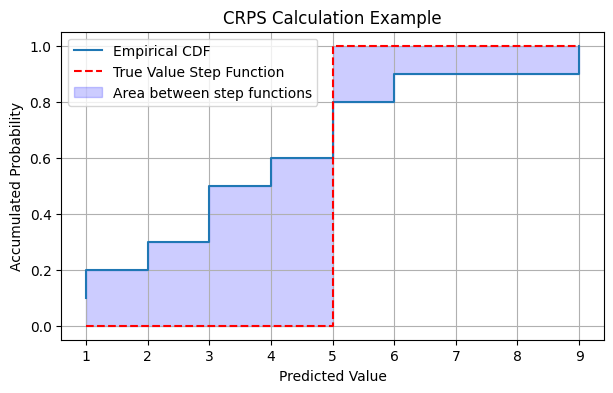

CRPS: 0.72


In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Input data
y_true = 5
y_pred = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3]

# Sort the data
sorted_y_pred = np.sort(y_pred)

# Compute the ECDF
ecdf_values = np.arange(1, len(sorted_y_pred) + 1) / len(sorted_y_pred)

# Compute the true value step function (Heaviside function)
true_step_function = np.where(sorted_y_pred < y_true, 0, 1)

# Plot the ECDF and the step function
fig, ax = plt.subplots(figsize=(7, 4))
ax.step(sorted_y_pred, ecdf_values, where="post", label="Empirical CDF")
ax.step(sorted_y_pred, true_step_function, where="post", label="True Value Step Function", linestyle='--', color='red')

# Fill the area between the two step functions: 
# Before the true value, fill between the ECDF and 0. After the true value, fill between the true value and 1.
n_lower = len(sorted_y_pred[sorted_y_pred < y_true])
ax.fill_between(sorted_y_pred[:n_lower+1], ecdf_values[:n_lower+1], 0, step='post', alpha=0.2, color='blue', label='Area between step functions')
ax.fill_between(sorted_y_pred[n_lower:], ecdf_values[n_lower:], 1, step='post', alpha=0.2, color='blue')

# Add labels and legend
ax.set_title("CRPS Calculation Example")
ax.grid(True)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Accumulated Probability")
ax.legend(loc="upper left")

# Show the plot
plt.show()

# Compute CRPS
differences = (ecdf_values - true_step_function)**2
widths = np.diff(np.concatenate(([0], sorted_y_pred)))
crps_value = np.sum(differences * widths)
print("CRPS:", crps_value)

In [172]:
import imageio
import io
import numpy as np
import matplotlib.pyplot as plt

frames = []

# Input data
y_true = 5
y_pred = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3]

# Sort the data and compute ECDF
sorted_y_pred = np.array(y_pred)[np.argsort(y_pred)]
ecdf_values = np.arange(1, len(sorted_y_pred) + 1) / len(sorted_y_pred)

# Compute the true value step function (Heaviside function)
true_step_function = np.where(sorted_y_pred < y_true, 0, 1)

def save_plot_to_frames(fig):
    """Save the current plot to frames."""
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    frames.append(imageio.imread(buf))
    buf.close()

# Initial plot setup
fig, ax = plt.subplots(figsize=(7, 4))

# Set title and grid before any plotting
ax.set_title("CRPS Calculation Example")
ax.grid(True)
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Accumulated Probability")
ax.set_ylim(-0.1, 1.1)

# First plot: ECDF
ax.step(sorted_y_pred, ecdf_values, where="post", label="Empirical CDF")
ax.legend()  # Ensure legend is shown in the first frame
save_plot_to_frames(fig)

# Second plot: Add true step function
ax.step(sorted_y_pred, true_step_function, where="post", label="True Value Step Function", linestyle='--', color='red')
ax.legend()  # Ensure legend is updated and visible
save_plot_to_frames(fig)

# Third plot: Fill between the ECDF and true value step function
n_lower = np.sum(sorted_y_pred < y_true)
ax.fill_between(sorted_y_pred[:n_lower + 1], ecdf_values[:n_lower + 1], 0, step='post', alpha=0.2, color='blue', label='Area between step functions')
ax.fill_between(sorted_y_pred[n_lower:], ecdf_values[n_lower:], 1, step='post', alpha=0.2, color='blue')
ax.legend()  # Ensure legend is updated and visible
save_plot_to_frames(fig)
save_plot_to_frames(fig) # Add an extra frame to pause for a bit

# Close the figure to avoid memory leaks
plt.close(fig)

# Save the frames as a gif that loops forever. Each frame will be displayed for 500 ms.
imageio.mimsave('crps.gif', frames, duration=600, loop=0)

C:\Users\Joaquín Amat\AppData\Local\Temp\ipykernel_11368\3114178646.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(buf))
